In [ ]:
# Comment the following lines if you're not in colab:
from google.colab import drive
drive.mount('/content/drive')
# If you're in colab, cd to your own working directory here:
%cd ..//..//content//drive//MyDrive//Colab-Notebooks//HY-673-Tutorials//Tutorial-7

In [ ]:
import numpy as np
import torch as tc
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.distributions import Normal

from torchsummary import summary
import matplotlib.pyplot as plt

seed = 42
tc.manual_seed(42)
tc.set_default_dtype(tc.float32)
device = 'cuda' if tc.cuda.is_available() else 'cpu'
print(f"using {device}")

using cuda


## <u>Flow-based GMs (key features)</u>:

+ **Invertibility**: The transformation they apply on the input is invertible.
    + **Sample Generation**: Sampling (i.e., generating new samples) is straightforward and efficient due to their invertible nature.
+ **Jacobian Determinant**: The change of variables formula requires the determinant of the Jacobian which is tractable in case of flows.
    + **Exact MLE**: They allow for exact likelihood evaluation also due to the fact that the Jacobian determinant is tractable.
+ **Composition of Flows**: Complex data distributions are modeled by composing multiple (invertible) ones, starting from a simple (normalized) base, e.g., Gaussian.

### <u>Masking</u>
How to create a mask with alternating $1$s and $0$s:

In [ ]:
# A mask example:
odd_mask = tc.zeros(20)
odd_mask[::2] = 1
odd_mask = odd_mask.float()
print(odd_mask)

# Same in one line:
odd_mask = ((tc.arange(20) + 1) % 2).float()
print(odd_mask)

tensor([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0.])
tensor([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0.])


How to get a tensor with random numbers from a normal distribution with mean $0$ and variance $1$:

In [ ]:
xx = tc.randn(20)
print(xx)

tensor([ 1.9269,  1.4873,  0.9007, -2.1055, -0.7581,  1.0783,  0.8008,  1.6806,
         0.3559, -0.6866, -0.4934,  0.2415, -0.2316,  0.0418, -0.2516,  0.8599,
        -0.3097, -0.3957,  0.8034, -0.6216])


Applying this mask to x will set the values at odd indices $(1,3,5,\dots)$ to zero, preserving only the even-indexed elements:

In [ ]:
xx_odd_masked = xx * odd_mask
print(xx_odd_masked)

tensor([ 1.9269,  0.0000,  0.9007, -0.0000, -0.7581,  0.0000,  0.8008,  0.0000,
         0.3559, -0.0000, -0.4934,  0.0000, -0.2316,  0.0000, -0.2516,  0.0000,
        -0.3097, -0.0000,  0.8034, -0.0000])


To get a mask that does the opposite, i.e., masks even-indexed values and preserves odd-indexed values, it is just:

In [ ]:
even_mask = 1 - odd_mask
print(even_mask)

tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1.])


So using this mask at x will yield:

In [ ]:
xx_even_masked = xx * even_mask
print(xx_even_masked)

tensor([ 0.0000,  1.4873,  0.0000, -2.1055, -0.0000,  1.0783,  0.0000,  1.6806,
         0.0000, -0.6866, -0.0000,  0.2415, -0.0000,  0.0418, -0.0000,  0.8599,
        -0.0000, -0.3957,  0.0000, -0.6216])


So, these two masked x's give the original x when added:

In [ ]:
print(xx == xx_even_masked + xx_odd_masked)

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True])


### <u>PyTorch Distributions</u>

To create an instance of a normal distribution $\mathcal{N}(0,1)$ as a PyTorch tensor:

In [ ]:
distribution = Normal(0, 1)

And to get $20$ samples from it:

In [ ]:
zz = distribution.sample((20,))
print(zz)

tensor([ 0.3189, -0.4245,  0.3057, -0.7746, -0.8371, -0.9224,  1.8113,  0.1606,
         0.3672,  0.1754,  1.3852, -0.4459, -1.2024,  0.7078, -1.0759,  0.5357,
         1.1754,  0.5612, -0.4527, -0.7718])


To get the log-likelihood for each sample (i.e., how likely is it that each of these 20 samples came from this distribution) we use the `log_prob()` method. This is the standard way to work with probability densities because this method is efficient and numerically stable:

In [ ]:
log_likelihoods = distribution.log_prob(zz)
print(log_likelihoods)

tensor([-0.9698, -1.0090, -0.9657, -1.2189, -1.2693, -1.3443, -2.5594, -0.9318,
        -0.9864, -0.9343, -1.8783, -1.0183, -1.6419, -1.1694, -1.4977, -1.0624,
        -1.6097, -1.0764, -1.0214, -1.2168])


The closer to $0$, the higher the likelihood (ln(1)=0), and the more negative the number, the lower the likelihood (ln(0+)=-inf).

In case we want to compute the probability density for each sample and then apply the (natural) logarithm, we just exponentiate (no other way offered by PyTorch):

In [ ]:
pdf_values = tc.exp(distribution.log_prob(zz))
log_likelihoods_too = tc.log(pdf_values)
print(log_likelihoods_too)

tensor([-0.9698, -1.0090, -0.9657, -1.2189, -1.2693, -1.3443, -2.5594, -0.9318,
        -0.9864, -0.9343, -1.8783, -1.0183, -1.6419, -1.1694, -1.4977, -1.0624,
        -1.6097, -1.0764, -1.0214, -1.2168])


Side note: When comparing floating-point numbers in PyTorch (or any other computing environment), it's recommended to use methods that allow for a tolerance of slight differences. For example, PyTorch's `torch.allclose()` function is designed for this purpose, comparing if two tensors are similar within a certain tolerance: <br>
https://pytorch.org/docs/stable/generated/torch.allclose.html

In [ ]:
print(f"equality operator:\n {log_likelihoods == log_likelihoods_too}")
print(f"\nlog_likelihoods[0]     = {log_likelihoods[0]:.8f}")
print(f"log_likelihoods_too[0] = {log_likelihoods_too[0]:.8f}")
print(f"\nallclose:\n {tc.allclose(log_likelihoods, log_likelihoods_too)}")

equality operator:
 tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True])

log_likelihoods[0]     = -0.96978086
log_likelihoods_too[0] = -0.96978080

allclose:
 True


## <u>Not-So-NICE (Gaussian Prior & No Scaling)</u>

We will build the Non-Linear Independent Components (NICE) model step by step throughout this entire tutorial:
https://arxiv.org/pdf/1410.8516.pdf

In this notebook, we will see what happens if we use a Gaussian prior and no scaling layer.

### <u>Additive Coupling</u>
This is a type of flow that we will implement that is necessary for NICE. Recap of additive coupling:
+ **Splitting Input**: We split the input $x$ in two equal parts $x_1$ and $x_2$. This allows for a part of the input to remain unchanged during the transformation and is essential for maintaining invertibility. We will achieve this halving by utilizing masks like the ones we showed before.
+ **Transformation**: In additive coupling, only one part of the input, e.g., $x_2$, is transformed based on the information from the unchanged part $x_1$. This transformation is parametrized by a function $m_\theta(x_1)$, which in our case $m$ will be a neural network with parameters $\theta$.
\begin{align}
&y_1 = x_1, \\
&y_2 = x_2 + m_{\theta}(x_1), \\
&y = \text{Concatenate}(y_1, y_2).
\end{align}
In practice, we will achieve this input splitting with our masks because it is easier this way. So, actually, we won't concatenate in the end, but we will just add. Also, we need to ensure that $m_\theta$ did not alter the masked values, so we can just reapply the mask afterwards to guarantee it.
+ **Invertibility**: Given the output $y=\text{Concatenate}(y_1, y_2)$, the inverse is directly:
\begin{align}
& x_1 = y_1, \\
& x_2 = y_2 - m_\theta(y_1).
\end{align}
The original paper does not specify which activation function was used, so we'll just put ReLU.

In [ ]:
class CouplingLayer(nn.Module):

  def __init__(self, inpt_dim, hid_dim, mask, n_layers=5):
    super().__init__()

    self.odd_mask = mask
    self.even_mask = 1 - self.odd_mask

    # m_theta definition:
    modules = [
        nn.Linear(inpt_dim, hid_dim),
        nn.ReLU()
    ]
    for _ in range(n_layers-2):
        modules.append(nn.Linear(hid_dim, hid_dim))
        modules.append(nn.ReLU())
    # Final layer maps to input_dim:
    modules.append(nn.Linear(hid_dim, inpt_dim))
    self.m = nn.Sequential(*modules)

  def forward(self, x):
      x1 = self.odd_mask * x
      x2 = self.even_mask * x
      y1 = x1
      # x_1's masked values must remain masked even after the m_theta transformation,
      # so we need to apply the opposite mask to guarantee that:
      y2 = x2 + (self.m(x1) * self.even_mask)
      return y1 + y2

  # Inverse mapping:
  def inverse(self, x):
    y1 = self.odd_mask * x
    y2 = self.even_mask * x
    x1 = y1
    x2 = y2 - (self.m(y1) * self.even_mask)
    return x1 + x2

Half of the masks cover even indices, the other half covers odd indices:

In [ ]:
# simple way:
def get_mask_1(dim, orientation=True):
  mask = tc.zeros(dim)
  mask[::2] = 1
  if orientation:
    mask = 1 - mask
  return mask.float()

Here's an alternative one-liner to do the same thing with the XOR ('^') operator:

In [ ]:
# pro way using the '^' XOR operator:
def get_mask(dim, orientation=True):
    return ((1 - tc.arange(dim) % 2) ^ orientation).float()

In [ ]:
print(get_mask(10, True) == get_mask_1(10, True))
print(get_mask(10, False) == get_mask_1(10, False))

tensor([True, True, True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True, True, True])


## <u>Input Transformation</u>

+ **Input to Latent Space (forward pass)**: The input data $x$ is transformed through a series of (invertible) coupling layers, which progressively change its distribution until it maches the prior distribution. Each coupling layer modifies part of its input based on the rest, in a manner that is invertible. The series of transformations is designed so that the final output $z$ of the last coupling layer ideally follows the prior distribution.
+ **Latent Space Representation**: The transformed data $z$ in the latent space is expected to follow a Normal distribution in our case for each dimension. The idea is that the complex, real-world distribution of the input can be "unfolded" into this simpler distribution through these invertible transformations.

## <u>Role of the Prior</u>
+ **Modeling the Base Distribution**: The prior acts as a base distribution that the model attempts to map its input onto through the invertible transformations. It provides a reference point or target for what the transformed data should look like if the model has correctly learned the data distribution.
+ **Likelihood Evaluation**: During training, the model evaluates how well the transformed data $z$ matches the prior distribution by computing the log-likelihood of z, i.e., $log(p(z))$, under the prior. This computation is facilitated by the choice of a simple prior, as the log-likelihood can be directly calculated. The sum of these log-likelihoods across dimensions or samples gives a measure of how well the overall model is performing.
+ **Sampling**: To generate new samples, the process is reversed. Samples are first drawn from the prior distribution $z$, and the passed through the inverse of the coupling transformations to produce samples in the data space $x$. That is why we create invertible transformations.

## <u>What Happens with the Prior</u>
+ **During the Forward Pass**: The prior does not directly interact with the input data $x$ or the transformations. Instead, it serves as the target distribution that the transformed data $z$ is expected to match.
+ **During Training**: The model's performance is assessed by how closely the transformed data $z$ aligns with the prior, using the log-likelihood of $z$ under the prior as a key metric.
+ **During Sampling**: The prior is actively used to generate initial samples in the latent space, which are then mapped back to the data space to produce new data sampled following the learned distribution.

## <u>Extra Clarifications</u>
+ $z$ is in the same high-dimensional space as the input $x$, which in the case of (flattened) MNIST images is 28*28=784-dimensional.
+ Each dimension of $z$ is encouraged to follow a standard normal distribution, making $z$ follow a multivariate normal distribution.
+ We want each dimension of $z$ to independently follow a standard normal distribution (so each dimension is an r.v.).
+ So we will sum all individual log-likelihoods and try to maximize this quantity, or, equivalently, minimize its negative.

## <u>Architecture</u>
+ We want to learn an invertible transformation that maps MNIST digits to a Gaussian distribution.
+ This architecture consists of a sequence of coupling layers with alternating masks:

In [ ]:
class NotSoNICE(nn.Module):
  def __init__(self, inpt_dim, hid_dim=1000, n_coupling_layers=3, n_layers=6):
    super().__init__()

    self.prior = Normal(0, 1)
    self.input_dim = inpt_dim
    self.hidden_dim = hid_dim
    self.num_coupling_layers = n_coupling_layers
    self.num_layers = n_layers

    # Alternating mask orientations for consecutive coupling layers:
    masks = [
        get_mask(inpt_dim, orientation=(i % 2 == 0)).to(device)
        for i in range(n_coupling_layers)
    ]

    self.coupling_layers = nn.ModuleList([
        CouplingLayer(
            inpt_dim=inpt_dim,
            hid_dim=hid_dim,
            mask=masks[i],
            n_layers=n_layers
        )
        for i in range(n_coupling_layers)
    ])

  def forward(self, x):
    """Pass through each coupling layer to reach the latent space: x->z."""
    z = x
    for i in range(len(self.coupling_layers)):
      z = self.coupling_layers[i](z)
    log_likel = tc.sum(self.prior.log_prob(z), dim=1)
    return z, log_likel

  # We don't call this during training: we will use it for inference (sampling):
  def inverse(self, z):
    """Pass through each coupling layer in reversed order: z->x'."""
    x = z
    for i in reversed(range(len(self.coupling_layers))):
      x = self.coupling_layers[i].inverse(x)
    return x

  def sample(self, num_samples):
    # Sample from prior (28*28 number of Gaussians):
    z = self.prior.sample([num_samples, self.input_dim]).view(num_samples, self.input_dim).to(device)
    # Inverse pass to get to data space:
    return self.inverse(z)

Using the original parameters proposed in the NICE paper (except number of epochs):

In [ ]:
length, height = 28, 28   # input size (MNIST)
input_dim = length * height
hidden_dim = 1000         # output size of the hidden layers
num_coupling_layers = 4   # number of coupling layers
num_layers = 5            # number of linear layers for each coupling layer

epochs = 30  # original paper: 1500
batch_size = 128
betas = (0.9, 0.01)
eps = 1e-4
lr = 1e-3

## <u>Dequantization</u>

A common practice in the case of GMs is to **dequantize** the input, meaning to partially reverse the effect of quantization by making the data less discrete and more continuous. In our case, one way to do this is by adding uniform noise, i.e., a small uniformly distributed r.v. to each pixel in the image. Dequantization also offers other advantages, such as, mitigating overfitting, helps the model become more robust, etc. While we're at it, we can also scale the image to be within a desired range, e.g. [0,1], to make it even more suitable for processing by NNs.
<br> In PyTorch, we can do that simply by defining it as a transformation that will be applied automatically to our entire dataset:

In [ ]:
class DequantizeAndScale(tc.nn.Module):
    def __init__(self, scale_range=(0, 1)):
        super().__init__()
        self.min_val, self.max_val = scale_range

    def forward(self, img):
        # Dequantize by adding uniform noise:
        img += tc.rand_like(img) / 256.0
        # Scale to desired range, e.g., [0, 1]:
        img *= (self.max_val - self.min_val) + self.min_val
        # Ensure values are within [0, 1]:
        return img.clamp(0, 1)

# Use the custom transform in a Compose with ToTensor
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    DequantizeAndScale()
])

And this transformation pipeline we defined above (convert to tensor, dequantize & scale) can be just passed as an argument in order for all of our batches to be preprocessed like that:

In [ ]:
# Define the dataset and data loader:
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform_pipeline)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Define the model:
model = NotSoNICE(
    inpt_dim=input_dim,
    n_coupling_layers=num_coupling_layers,
    n_layers=num_layers
).to(device)
# may not work in colab:
_ = summary(model=model)

Layer (type:depth-idx)                   Param #
├─ModuleList: 1-1                        --
|    └─CouplingLayer: 2-1                --
|    |    └─Sequential: 3-1              4,572,784
|    └─CouplingLayer: 2-2                --
|    |    └─Sequential: 3-2              4,572,784
|    └─CouplingLayer: 2-3                --
|    |    └─Sequential: 3-3              4,572,784
|    └─CouplingLayer: 2-4                --
|    |    └─Sequential: 3-4              4,572,784
Total params: 18,291,136
Trainable params: 18,291,136
Non-trainable params: 0


## <u>Reconstruction (forward -> inverse) sanity check:</u>

A key feature of normalizing flow-based GMs that sets them apart from other GMs is that each transformation (i.e, flow) is designed to be mathematically **invertible**. This allows for transforming data points back and forth between the data space and the latent space without losing information. In other words, if we do a forward and then inverse pass we should get back our original input unaltered. We can perform this as a sanity check whenever we build such a model to see if we're on the right track:

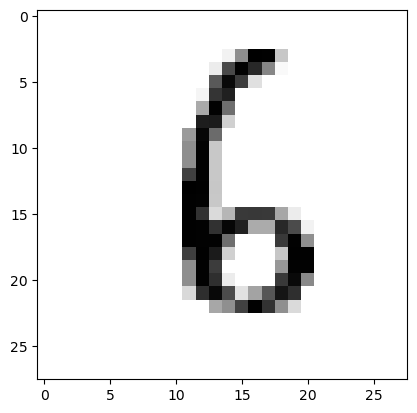

In [ ]:
def reconstruction():
    x_batch, _ = next(iter(train_loader))
    x_batch = x_batch.to(device).view(-1, input_dim)

    out, _ = model(x_batch)
    x_hat = model.inverse(out)

    plt.figure()
    plt.imshow(x_hat[0].detach().cpu().numpy().reshape(height, length), cmap='binary')
    plt.show()

reconstruction()

## <u>Training and Inference</u>

Here is a function that samples from the model and plots the sampled digits. We will use it to see the progress of our model turing training. <br>
Note: Like most unconditional GMs, generating specific categories or types of data, say, a specific digit from MNIST, isn't inherently possible directly from the model. Our model focuses on learning a complex data distribution without conditioning on additional information such as class label.

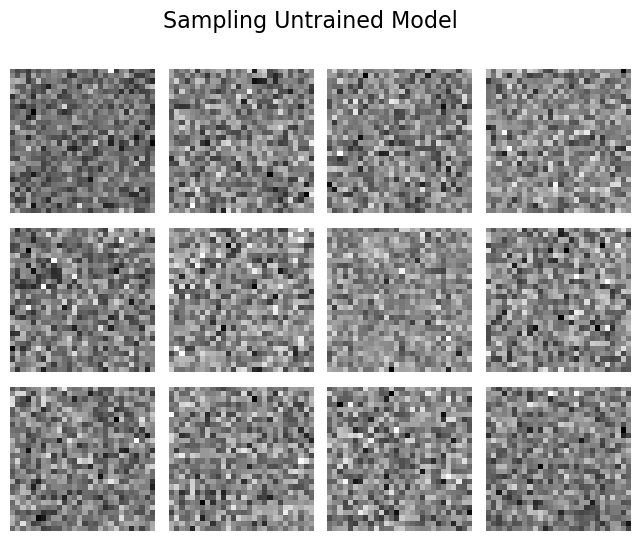

In [ ]:
def sample_model(n_samples=12, title="None"):
    # Model sampling happens here:
    x_hat = model.sample(n_samples)
    x_hat = x_hat.cpu().detach().numpy().reshape(n_samples, height, length)
    # The rest is just plotting:
    n_rows = (n_samples + 3) // 4
    fig, axs = plt.subplots(
        nrows=n_rows,
        ncols=4,
        figsize=(8, 2*n_rows),
        subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False}
    )
    for i, ax in enumerate(axs.flat[:n_samples]):
        ax.imshow(x_hat[i], cmap='binary')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.suptitle(title, fontsize=16)
    plt.show()
    plt.close()

model.eval()
sample_model(n_samples=12, title="Sampling Untrained Model")

### <u>Gradient Clipping</u>
Gradient clipping is a technique to prevent exploding gradients in neural networks, a common issue that can derail the training process. It is not specifically mentioned in the original NICE paper, but I personally encountered this issue while training these models sometimes. The way it works is very simple and straightforward: We basically define a maximum allowed norm for the gradients, e.g., `max_norm=1.0`, preventing them to go above this threshold. This happens after backpropagation and before updating the weights, where we basically scale down gradients with norm > max_norm while preserving their direction.  In PyTorch, this is just done with one line as you'll see below in the loop.
### <u>Training Loop</u>
As we've said, we want to maximize the log-likelihood, or, equivalently, minimize the negative (mean) log-likelihood (NLL):

469it [00:14, 32.51it/s]


Epoch 1/30 | Mean NLL (Loss): 742.3587


469it [00:14, 32.61it/s]


Epoch 2/30 | Mean NLL (Loss): 733.5889


469it [00:14, 32.67it/s]


Epoch 3/30 | Mean NLL (Loss): 730.7241


469it [00:14, 32.34it/s]


Epoch 4/30 | Mean NLL (Loss): 729.1724


469it [00:14, 32.01it/s]


Epoch 5/30 | Mean NLL (Loss): 728.2397


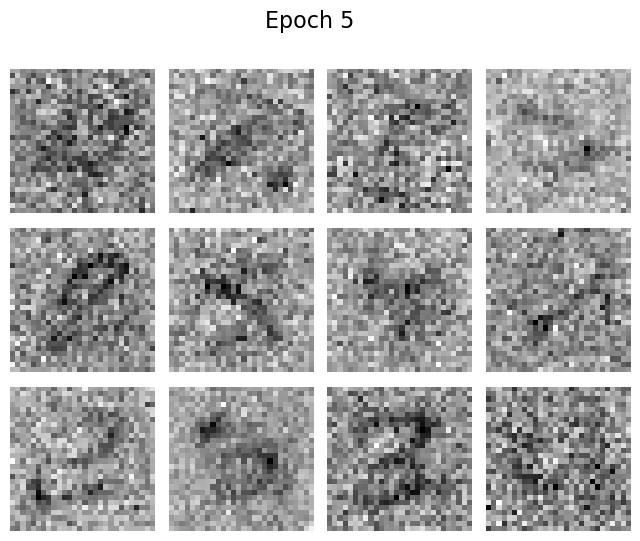

469it [00:14, 32.95it/s]


Epoch 6/30 | Mean NLL (Loss): 727.5907


469it [00:14, 32.92it/s]


Epoch 7/30 | Mean NLL (Loss): 727.0918


469it [00:14, 32.49it/s]


Epoch 8/30 | Mean NLL (Loss): 726.7013


469it [00:14, 32.46it/s]


Epoch 9/30 | Mean NLL (Loss): 726.3679


469it [00:14, 32.72it/s]


Epoch 10/30 | Mean NLL (Loss): 726.1413


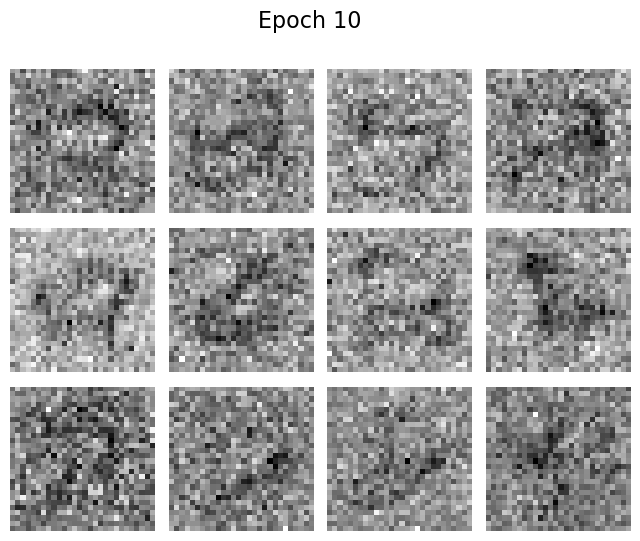

469it [00:14, 32.15it/s]


Epoch 11/30 | Mean NLL (Loss): 725.9275


469it [00:14, 32.27it/s]


Epoch 12/30 | Mean NLL (Loss): 725.7267


469it [00:14, 32.15it/s]


Epoch 13/30 | Mean NLL (Loss): 725.5814


469it [00:14, 32.11it/s]


Epoch 14/30 | Mean NLL (Loss): 725.4305


469it [00:14, 31.93it/s]


Epoch 15/30 | Mean NLL (Loss): 725.3095


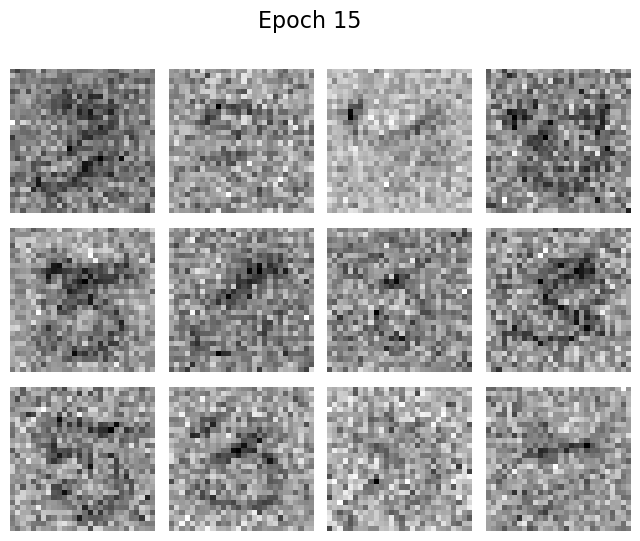

469it [00:14, 31.71it/s]


Epoch 16/30 | Mean NLL (Loss): 725.1918


469it [00:14, 32.13it/s]


Epoch 17/30 | Mean NLL (Loss): 725.0905


469it [00:14, 32.04it/s]


Epoch 18/30 | Mean NLL (Loss): 725.0291


469it [00:14, 32.08it/s]


Epoch 19/30 | Mean NLL (Loss): 724.9300


469it [00:14, 32.02it/s]


Epoch 20/30 | Mean NLL (Loss): 724.8443


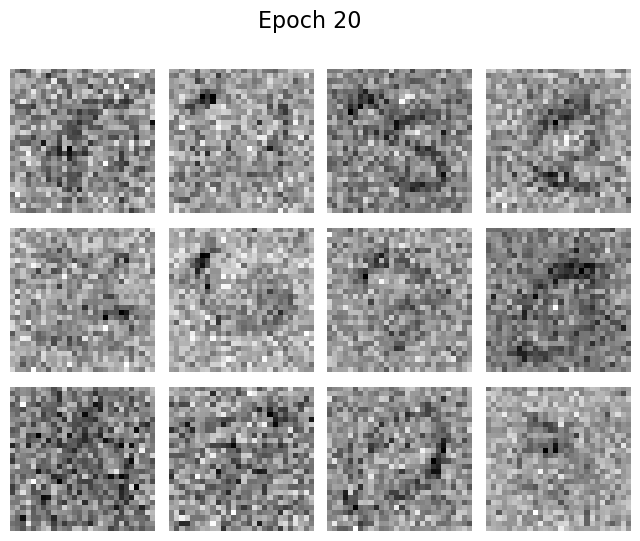

469it [00:14, 31.84it/s]


Epoch 21/30 | Mean NLL (Loss): 724.7953


469it [00:14, 32.25it/s]


Epoch 22/30 | Mean NLL (Loss): 724.7419


469it [00:14, 32.49it/s]


Epoch 23/30 | Mean NLL (Loss): 724.6918


469it [00:14, 32.41it/s]


Epoch 24/30 | Mean NLL (Loss): 724.6140


469it [00:14, 32.55it/s]


Epoch 25/30 | Mean NLL (Loss): 724.5838


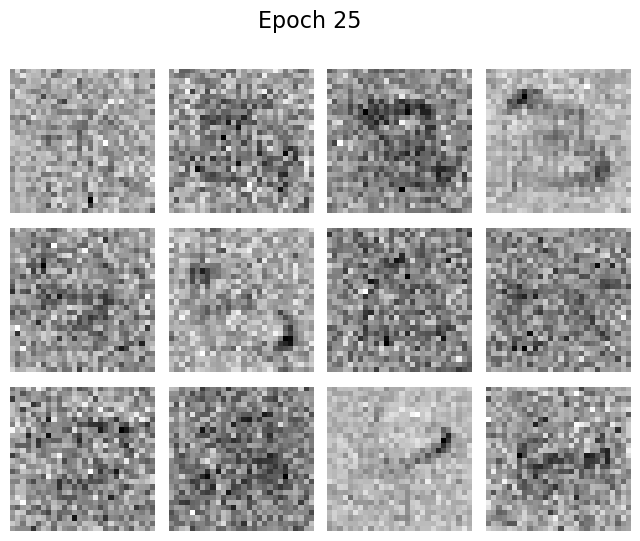

469it [00:14, 32.78it/s]


Epoch 26/30 | Mean NLL (Loss): 724.5493


469it [00:14, 32.61it/s]


Epoch 27/30 | Mean NLL (Loss): 724.5018


469it [00:14, 32.57it/s]


Epoch 28/30 | Mean NLL (Loss): 724.4563


469it [00:14, 32.99it/s]


Epoch 29/30 | Mean NLL (Loss): 724.4213


469it [00:14, 32.73it/s]


Epoch 30/30 | Mean NLL (Loss): 724.3701


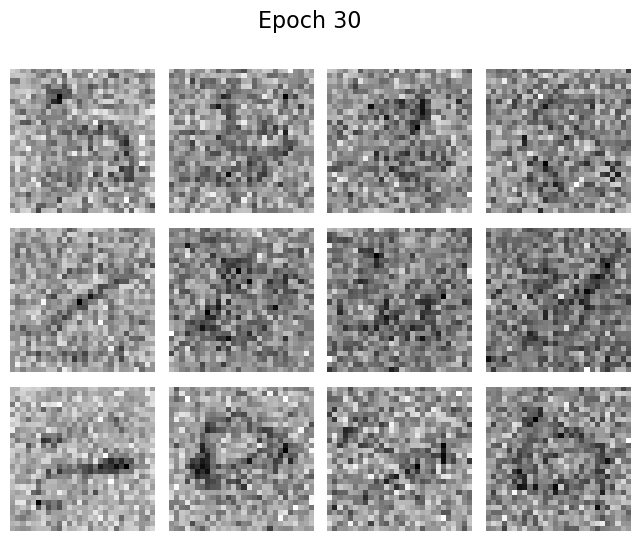

In [ ]:
def train_loop():

    print_every = 5
    optimizer = Adam(params=model.parameters(), lr=lr, betas=betas, eps=eps)
    # Put model in training mode:
    model.train()
    # Main training loop:
    losses_ = np.zeros(epochs)

    for epoch in range(epochs):
        tot_mean_nll = 0.0

        for batch_id, (x, _) in tqdm(enumerate(train_loader)):
            # Zero gradients:
            model.zero_grad()
            # Move to device and flatten:
            x = x.to(device).view(-1, input_dim)
            # Call model:
            _, log_likelihood = model(x)
            # Compute mean NLL loss:
            loss = -tc.mean(log_likelihood)
            # Backpropagate:
            loss.backward()
            # Gradient clipping:
            tc.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
            # Update weights:
            optimizer.step()
            # Add loss:
            tot_mean_nll += loss.item()

        # Take the mean over each epoch and print:
        mean_nll = tot_mean_nll / len(train_loader)
        losses_[epoch] = mean_nll
        print(f'Epoch {epoch+1}/{epochs} | Mean NLL (Loss): {mean_nll:.4f}')
        if (epoch + 1) % print_every == 0:
            model.eval()
            sample_model(n_samples=12, title=f"Epoch {epoch + 1}")
            model.train()

    return losses_

losses = train_loop()

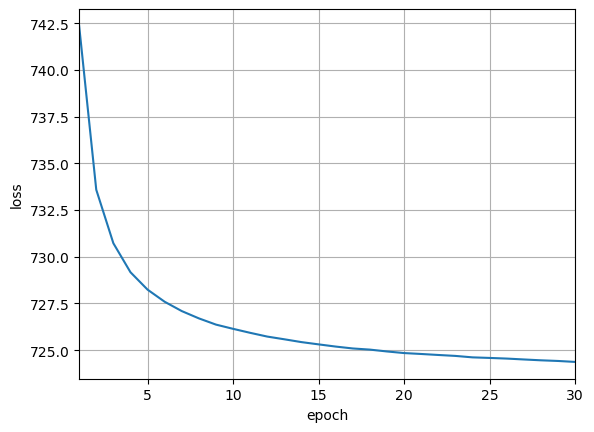

In [ ]:
epoch_ax = np.arange(start=1, stop=epochs+1, step=1)
plt.figure()
plt.plot(epoch_ax, losses)
plt.xlim([1, epochs])
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()
plt.close()